In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Data/combined.csv')
new_index=df['Player']
df.index=new_index
df.rename(columns={'Weekly':'Wages'},inplace=True)
df.columns

Index(['Unnamed: 0', 'Player', 'Wages', 'Pos', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'xG', 'xA', 'Sh', 'SoT', 'G/Sh', 'G/SoT', 'Dist', 'FK',
       'PK', 'G-xG', 'SCA90', 'GCA90', 'Cmp', 'Att', 'TotDist', 'PrgDist',
       'S.Cmp', 'S.Att', 'M.Cmp', 'M.Att', 'L.Cmp', 'L.Att', 'KP', '1/3',
       'PPA', 'CrsPA', 'Prog', 'PressPass', 'Cross', 'TchDefP', 'TchDef3',
       'TchMid3', 'TchAtt3', 'TchAttP', 'DrSucc', 'DrPast', 'ProgCrr',
       'Crr1/3', 'CPA', 'Tkl', 'TklW', 'TklDef3', 'TklMid3', 'TklAtt3',
       'Press', 'Succ', 'PrsDef3', 'PrsMid3', 'PrsAtt3', 'Blocks', 'Int',
       'Clr', 'Squad', 'Recov', 'ArDuWon%', 'PrgPassDist'],
      dtype='object')

From the exploratory data anlaysis, we concluded that only a few indicators will be used to model the wages. Other performance-related columns are dropped. The total minutes played and no of minutes played are retained. Age could also influence the wage. However, that will be incorporated leter.

In [3]:
df.drop(['Unnamed: 0', 'Player','MP', 
       'Gls', 'Ast', 'G/Sh', 'G/SoT', 'Dist', 'FK',
       'PK', 'G-xG','Cmp', 'Att', 'TotDist', 'PrgDist',
       'S.Cmp', 'S.Att', 'M.Cmp', 'M.Att', 'L.Cmp', 'L.Att',
        'CrsPA','PressPass', 'Cross', 'TchDefP', 'TchDef3',
       'TchMid3', 'TchAtt3', 'TchAttP', 'DrSucc', 'DrPast', 
       'Tkl', 'TklW', 'TklDef3', 'TklMid3', 'TklAtt3',
       'Press', 'Succ', 'PrsDef3', 'PrsMid3', 'PrsAtt3', 'Blocks', 'Int',
       'Clr', 'Recov', 'ArDuWon%', 'PrgPassDist'],axis=1,inplace=True)
df.rename(columns={'1/3':'Pto3','Crr1/3':'Crrto3'},inplace=True)
df.head()

,Wages,Pos,Starts,Min,90s,xG,xA,Sh,SoT,SCA90,GCA90,KP,Pto3,PPA,Prog,ProgCrr,Crrto3,CPA,Squad
Player,,,,,,,,,,,,,,,,,,,
Aaron Cresswell,50000,DF,21,1860,20.7,0.03,0.11,0.58,0.10,1.98,0.24,1.35,3.96,0.87,5.65,3.38,1.64,0.05,WHU
Aaron Lennon,10577,MFFW,11,983,10.9,0.06,0.03,0.64,0.18,1.74,0.37,0.37,0.55,0.28,1.01,2.57,0.83,0.92,BUR
Aaron Ramsdale,71154,GK,22,1980,22.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91,0.00,0.00,0.00,0.00,0.00,ARS
Aaron Wan-Bissaka,90000,DF,18,1613,17.9,0.01,0.05,0.22,0.06,1.73,0.06,0.78,2.07,0.67,2.68,4.92,1.79,0.22,MUN
Abdoulaye Doucouré,75000,MF,18,1594,17.7,0.11,0.08,1.36,0.34,2.20,0.34,0.79,3.22,0.79,3.50,3.16,1.24,0.28,EVE


Defenders and goalkeeper are dropped as we base our model purely on attacking performance. Nevertheless, there are defenders who contribute heavily in the attacking phase for many teams. Players who have not clocked atleast 450 minutes on the pitch (equivalent to 5 matches) are also dropped.

In [4]:
df.drop(df.index[df['Pos']=='GK'],inplace=True)
df.drop(df.index[df['Pos']=='DF'],inplace=True)
df.drop(df.index[df['90s']<5],inplace=True)
df['Pos'].unique()

array(['MFFW', 'MF', 'FW', 'FWMF', 'MFDF', 'DFMF', 'FWDF'], dtype=object)

Wage outliers have to be dropped, unless their performace indicators aren't outliers too (Exceptional performance deserves exceptional wages). To find performance ouutliers, a crude measurement, that is the sum of the all performance indicators, is used.

In [5]:
upper_bound_wage=2.5*df['Wages'].quantile(0.75)-1.5*df['Wages'].quantile(0.25)
wage_outliers=set(df.index[df.Wages>upper_bound_wage])

df['Performance']=df.xG+df.xA+df.Sh+df.SoT+df.SCA90+df.GCA90+df.KP+df.Pto3+df.PPA+df.Prog+df.ProgCrr+df.Crrto3+df.CPA
upper_bound_perf=2.5*df['Performance'].quantile(0.75)-1.5*df['Performance'].quantile(0.25)
perf_outliers=set(df.index[df.Performance>upper_bound_perf])

sdf=df.drop(wage_outliers.difference(perf_outliers))
sdf.drop('Performance',axis=1,inplace=True)

We noticed in the earlier analysis that salary varies for different positions so this information is retained. The position feature is converted to dummy variables.

In [6]:
sdf=pd.concat([sdf,pd.get_dummies(sdf['Pos'])], axis=1)
sdf.drop('Pos',axis=1,inplace=True)
sdf.rename(columns={'SCA90':'SCA','GCA90':'GCA','Pto3':'Ps3','Prog':'PrP','ProgCrr':'PrC','Crrto3':'Cr3'},inplace=True)
sdf.head()

,Wages,Starts,Min,90s,xG,xA,Sh,SoT,SCA,GCA,...,Cr3,CPA,Squad,DFMF,FW,FWDF,FWMF,MF,MFDF,MFFW
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Lennon,10577,11,983,10.9,0.06,0.03,0.64,0.18,1.74,0.37,...,0.83,0.92,BUR,0,0,0,0,0,0,1
Abdoulaye Doucouré,75000,18,1594,17.7,0.11,0.08,1.36,0.34,2.20,0.34,...,1.24,0.28,EVE,0,0,0,0,1,0,0
Adam Armstrong,47885,14,1216,13.5,0.30,0.13,3.26,1.04,1.92,0.22,...,1.26,1.19,SOU,0,1,0,0,0,0,0
Adam Forshaw,20000,14,1260,14.0,0.02,0.08,0.86,0.29,1.71,0.07,...,0.93,0.07,LEE,0,0,0,0,1,0,0
Adam Idah,5000,6,625,6.9,0.29,0.09,2.03,0.58,1.73,0.14,...,0.43,0.29,NOR,0,0,0,1,0,0,0


## Preliminary analysis : wages vs performance indicators
We do some preliminary analysis to check the qualitative dependence on starts, minutes played and performance indicators.

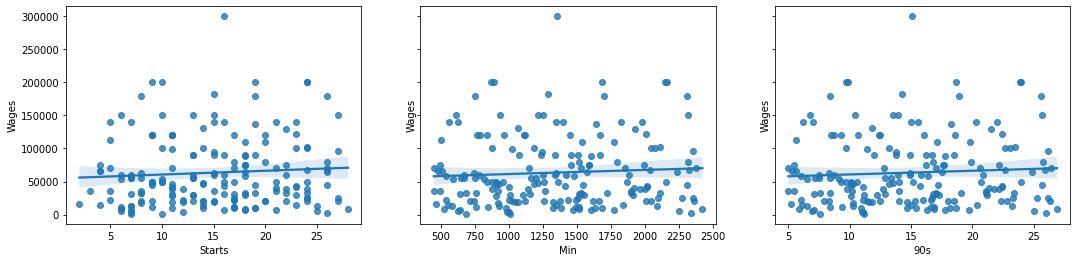

In [7]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Starts',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Min',y='Wages',data=sdf,ax=axes[1])
sns.regplot(x='90s',y='Wages',data=sdf,ax=axes[2])

The total minutes played (thus 90s) and starts made have no effect on the wages of the players. These parameters are dropped. 

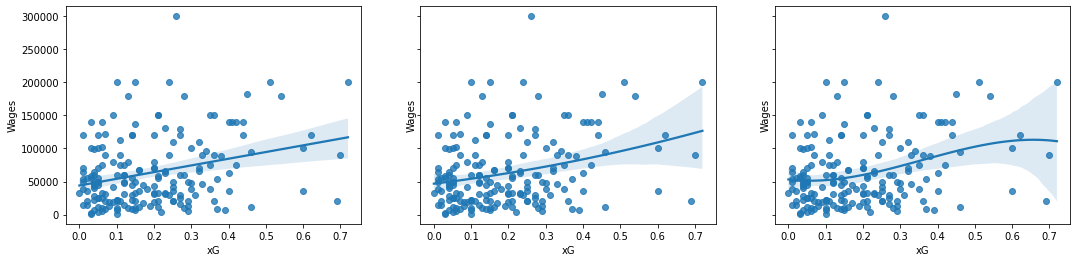

In [8]:
#sdf.drop(['Starts','Min','90s'],axis=1,inplace=True)
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='xG',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='xG',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='xG',y='Wages',data=sdf,order=3,ax=axes[2])

A linear dependence on _xG_ is used for modelling. We apply feature scaling so that the values are in the same range as the _dummy variables_ created for position. The minimum and range for each column are saved for use to predict new data.

In [9]:
xG_min=sdf.xG.min()
xG_max=sdf.xG.max()
sdf.xG=(sdf.xG-xG_min)/(xG_max-xG_min)

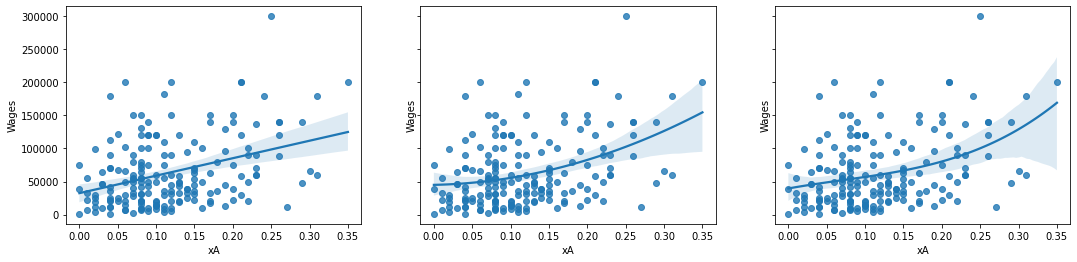

In [10]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='xA',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='xA',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='xA',y='Wages',data=sdf,order=3,ax=axes[2])

A quadratic dependence on _xA_ is used for modelling. For that we create an extra feature. Using _PolynomialFeatures_ function is avoided as it creates polynomials which are products of two different features.

In [11]:
xA_min=sdf.xA.min()
xA_max=sdf.xA.max()
sdf.xA=(sdf.xA-xA_min)/(xA_max-xA_min)
sdf['xA2']=sdf['xA']**2

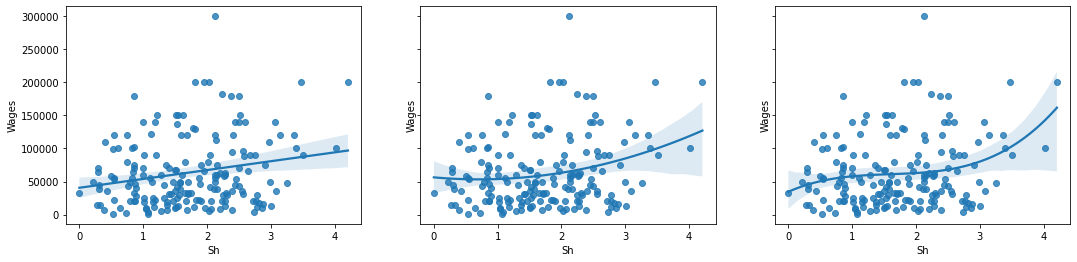

In [12]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Sh',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Sh',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='Sh',y='Wages',data=sdf,order=3,ax=axes[2])

For shots, we choose a 3rd degree polynomial.

In [13]:
Sh_min=sdf.Sh.min()
Sh_max=sdf.Sh.max()
sdf.Sh=(sdf.Sh-Sh_min)/(Sh_max-Sh_min)
sdf['Sh2']=sdf['Sh']**2
sdf['Sh3']=sdf['Sh']**3

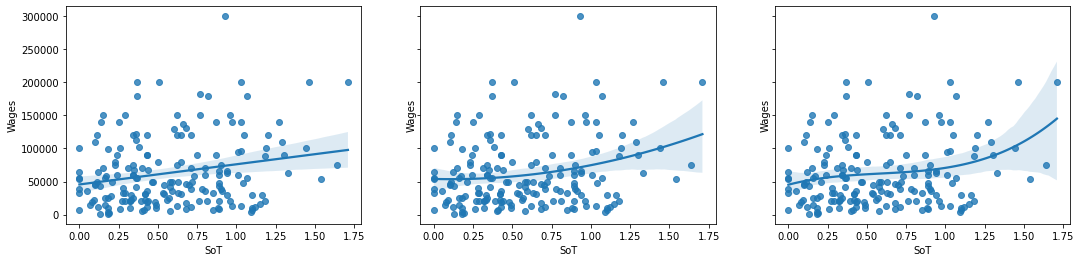

In [14]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='SoT',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='SoT',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='SoT',y='Wages',data=sdf,order=3,ax=axes[2])

A 3rd degree polynomial is chosen for shots on target as well.

In [15]:
SoT_min=sdf.SoT.min()
SoT_max=sdf.SoT.max()
sdf.SoT=(sdf.SoT-SoT_min)/(SoT_max-SoT_min)
sdf['SoT2']=sdf['SoT']**2
sdf['SoT3']=sdf['SoT']**3

(-20631.25848933396, 310000.0)

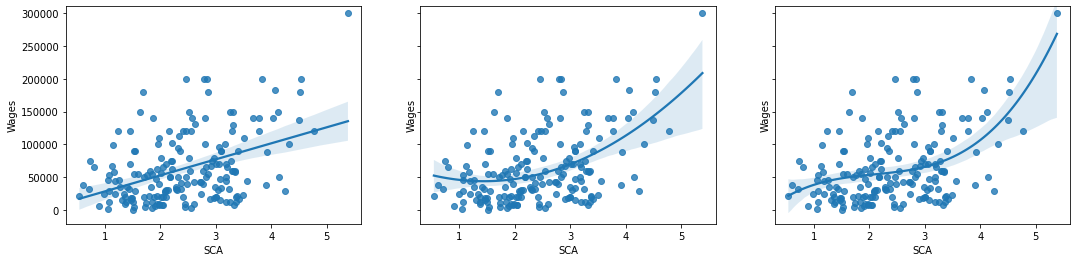

In [16]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='SCA',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='SCA',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='SCA',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim(top=310000)

In this case also, a third degree polynomial dependence is assumed.

In [17]:
SCA_min=sdf.SCA.min()
SCA_max=sdf.SCA.max()
sdf.SCA=(sdf.SCA-SCA_min)/(SCA_max-SCA_min)
sdf['SCA2']=sdf['SCA']**2
sdf['SCA3']=sdf['SCA']**3

(0.0, 310000.0)

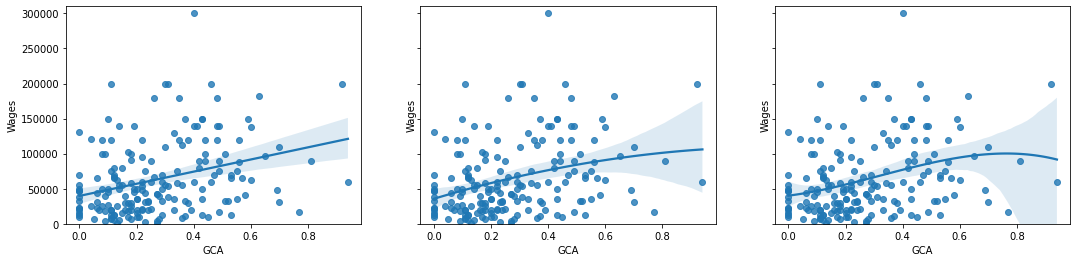

In [18]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='GCA',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='GCA',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='GCA',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

The relation between GCA and salary is linear.

In [19]:
GCA_min=sdf.GCA.min()
GCA_max=sdf.GCA.max()
sdf.GCA=(sdf.GCA-GCA_min)/(GCA_max-GCA_min)

(0.0, 310000.0)

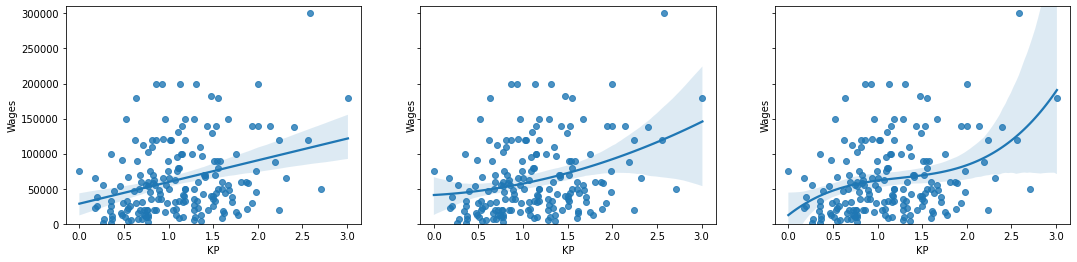

In [20]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='KP',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='KP',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='KP',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

The relationship between key passes and wages will also be assumed as linear. 

In [21]:
KP_min=sdf.KP.min()
KP_max=sdf.KP.max()
sdf.KP=(sdf.KP-KP_min)/(KP_max-KP_min)

(0.0, 310000.0)

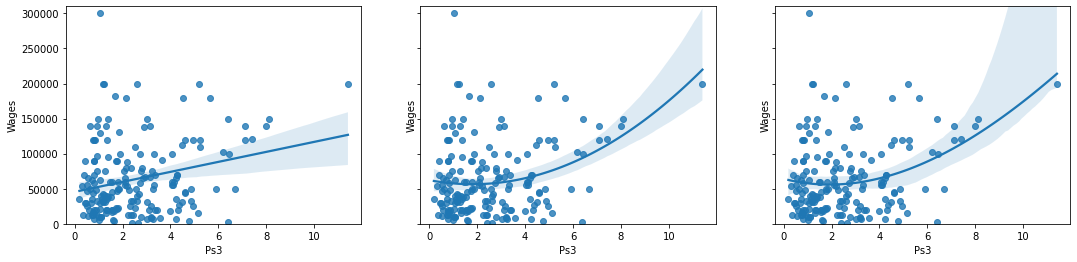

In [22]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Ps3',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Ps3',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='Ps3',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

A quadratic variation of wages with passes in the final 3rd is reasonable based on the figures.

In [23]:
Ps3_min=sdf.Ps3.min()
Ps3_max=sdf.Ps3.max()
sdf.Ps3=(sdf.Ps3-Ps3_min)/(Ps3_max-Ps3_min)
sdf['Ps32']=sdf['Ps3']**2

(0.0, 310000.0)

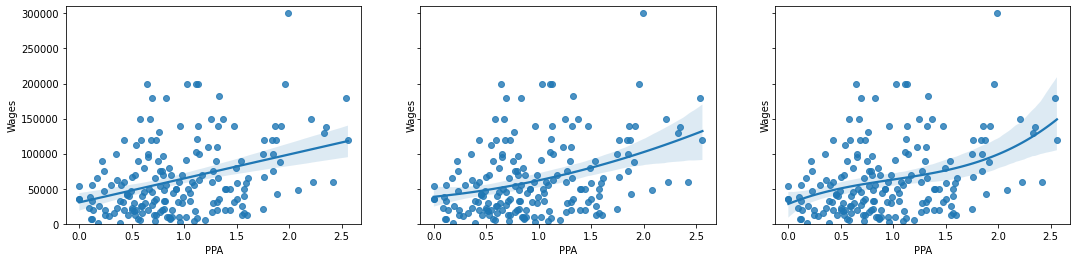

In [24]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='PPA',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='PPA',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='PPA',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

A cubic variation of salary with passes to opposition penalty box is a reasonable approximation.

In [25]:
PPA_min=sdf.PPA.min()
PPA_max=sdf.PPA.max()
sdf.PPA=(sdf.PPA-PPA_min)/(PPA_max-PPA_min)
sdf['PPA2']=sdf['PPA']**2
sdf['PPA3']=sdf['PPA']**3

(0.0, 310000.0)

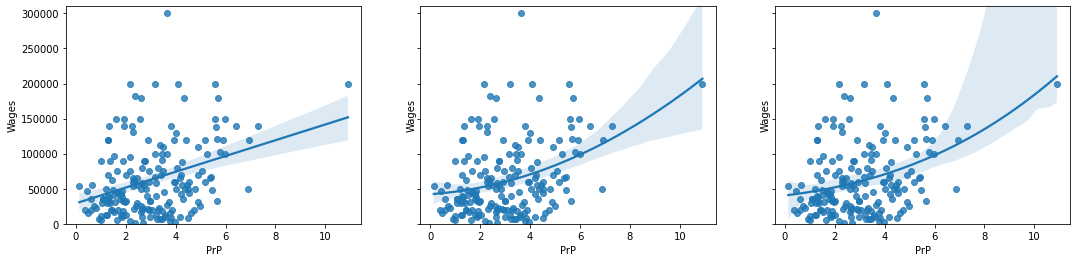

In [26]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='PrP',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='PrP',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='PrP',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

The relation between wages and progressive passes is specified as quadratic.

In [27]:
PrP_min=sdf.PrP.min()
PrP_max=sdf.PrP.max()
sdf.PrP=(sdf.PrP-PrP_min)/(PrP_max-PrP_min)
sdf['PrP2']=sdf['PrP']**2

(0.0, 310000.0)

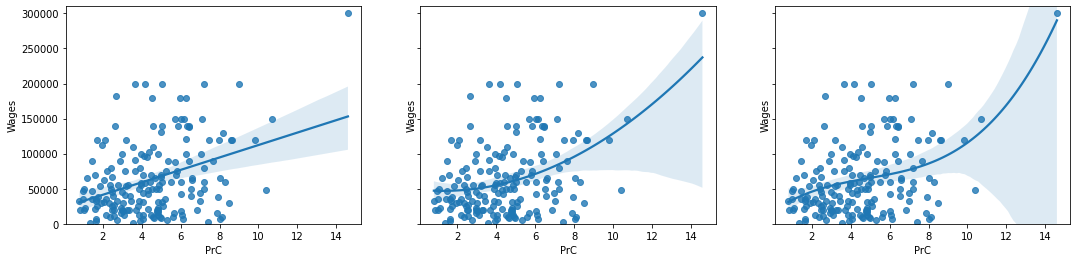

In [28]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='PrC',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='PrC',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='PrC',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

A quadratic relation is a reasonable approximation of salary dependence on progressive carries.

In [29]:
PrC_min=sdf.PrC.min()
PrC_max=sdf.PrC.max()
sdf.PrC=(sdf.PrC-PrC_min)/(PrC_max-PrC_min)
sdf['PrC2']=sdf['PrC']**2

(0.0, 310000.0)

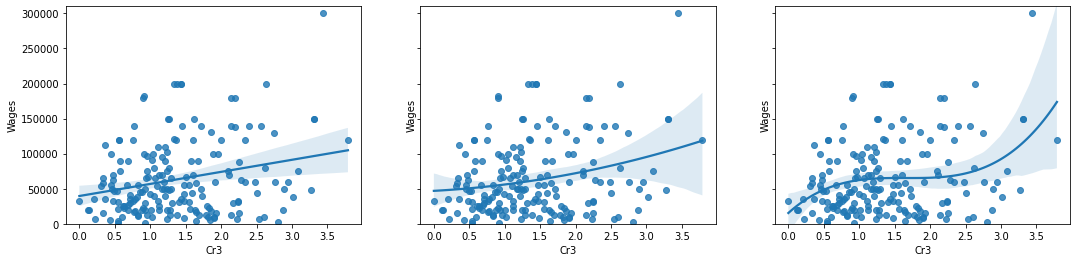

In [30]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='Cr3',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='Cr3',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='Cr3',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

Carries to the final third is quite valuable. So we approximate it as third-degree.

In [31]:
Cr3_min=sdf.Cr3.min()
Cr3_max=sdf.Cr3.max()
sdf.Cr3=(sdf.Cr3-Cr3_min)/(Cr3_max-Cr3_min)
sdf['Cr32']=sdf['Cr3']**2
sdf['Cr33']=sdf['Cr3']**3

(0.0, 310000.0)

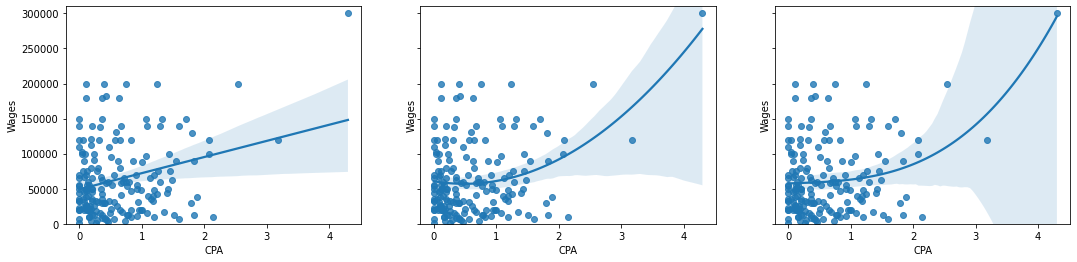

In [32]:
fig,axes = plt.subplots(1,3,figsize=(18,4),sharey=True)
sns.regplot(x='CPA',y='Wages',data=sdf,ax=axes[0])
sns.regplot(x='CPA',y='Wages',data=sdf,order=2,ax=axes[1])
sns.regplot(x='CPA',y='Wages',data=sdf,order=3,ax=axes[2])
plt.ylim([0,310000])

Carries to opposition box are also valuable. Carries also have an entertainment value. We stick to 3rd degree polynomial.

In [33]:
CPA_min=sdf.CPA.min()
CPA_max=sdf.CPA.max()
sdf.CPA=(sdf.CPA-CPA_min)/(CPA_max-CPA_min)
sdf['CPA2']=sdf['CPA']**2
sdf['CPA3']=sdf['CPA']**3

# Features used for modelling

Now that we have established the approximate relation between performance indicators and wages, let us look at the features that will be used to train the model.

- xG
- xA (quadratic)
- Shots (cubic)
- Shots on target (cubic)
- Shot creating actions (cubic)
- Goal creating actions
- Key passes 
- Passes to final third (quadratic)
- Passes to opposition box (cubic)
- Progressive passes (quadratic)
- Progressive carries (quadratic)
- Carries to final third (cubic)
- Carries to opposition box (cubic)

Thus there are 29 features, in total. We shall build three different models
1. Linear - assuming only linear dependence (13 features)
2. Quadratic - considering quadratic variations also (23 features)
3. Cubic - accounting for cubic variations

**Caution** : It must be noted that our objective is to obtain a mean or reasonable wage based on the performance. It is obvious from the figures reported above that a good fit is extremely difficult given the scatter.

In [34]:
X_lin = sdf[['xG','xA','Sh','SoT','SCA','GCA','KP','Ps3','PPA','PrP','PrC','Cr3','CPA']]
X_qud = sdf[['xG','xA','Sh','SoT','SCA','GCA','KP','Ps3','PPA','PrP','PrC','Cr3','CPA',
            'xA2','Sh2','SoT2','SCA2','Ps32','PPA2','PrP2','PrC2','Cr32','CPA2',]]
X_cub = sdf[['xG','xA','Sh','SoT','SCA','GCA','KP','Ps3','PPA','PrP','PrC','Cr3','CPA',
            'xA2','Sh2','SoT2','SCA2','Ps32','PPA2','PrP2','PrC2','Cr32','CPA2',
            'Sh3','SoT3','SCA3','PPA3','Cr33','CPA3',]]
Y = sdf[['Wages']]

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

Ridge regression is employed to counter overfitting and GridSearchCV is used for hyperparameter optimization.

## Linear model

In [36]:
params = [{'alpha':[0.001,0.01,0.1,1,10,100,1000]}]
RR_lin = Ridge()
Grid_lin = GridSearchCV(RR_lin,params,cv=4)
Grid_lin.fit(X_lin,Y)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}])

In [37]:
Grid_lin.best_estimator_

Ridge(alpha=1)

In [38]:
scores_lin=Grid_lin.cv_results_
scores_lin['mean_test_score']

array([0.25554579, 0.25839302, 0.27728176, 0.29121627, 0.20986865,
       0.07731807, 0.00329419])

## Quadratic model

In [39]:
RR_qud = Ridge()
Grid_qud = GridSearchCV(RR_qud,params,cv=4)
Grid_qud.fit(X_qud,Y)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}])

In [40]:
Grid_qud.best_estimator_

Ridge(alpha=1)

In [41]:
scores_qud=Grid_qud.cv_results_
scores_qud['mean_test_score']

array([0.22497371, 0.2394181 , 0.29047241, 0.32688147, 0.24345105,
       0.10952289, 0.01014117])

## Cubic model

In [42]:
RR_cub = Ridge()
Grid_cub = GridSearchCV(RR_cub,params,cv=4)
Grid_cub.fit(X_cub,Y)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}])

In [43]:
Grid_cub.best_estimator_

Ridge(alpha=1)

In [44]:
scores_cub=Grid_cub.cv_results_
scores_cub['mean_test_score']

array([0.26651002, 0.2854647 , 0.30759837, 0.34055807, 0.25281446,
       0.12133429, 0.01328263])

With regularization and hyperparameter optimization, we have found **the best model to be the one with third-degree polynomials and $\alpha=1$.** The model is now trained using the entire set.

In [45]:
WageModel = Ridge(alpha=1)
WageModel.fit(X_cub,Y)
WageModel.score(X_cub,Y)

0.4482455976809193

# Post-modelling analysis
We shall now look at the entire dataset of forwards and midfielders, with the outliers included. Remember, our objective is to quantify the variation from a reasonable wage measure. We must do the same transformations we applied to the training set.

In [46]:
df.head()

,Wages,Pos,Starts,Min,90s,xG,xA,Sh,SoT,SCA90,GCA90,KP,Pto3,PPA,Prog,ProgCrr,Crrto3,CPA,Squad,Performance
Player,,,,,,,,,,,,,,,,,,,,
Aaron Lennon,10577,MFFW,11,983,10.9,0.06,0.03,0.64,0.18,1.74,0.37,0.37,0.55,0.28,1.01,2.57,0.83,0.92,BUR,9.55
Abdoulaye Doucouré,75000,MF,18,1594,17.7,0.11,0.08,1.36,0.34,2.20,0.34,0.79,3.22,0.79,3.50,3.16,1.24,0.28,EVE,17.41
Adam Armstrong,47885,FW,14,1216,13.5,0.30,0.13,3.26,1.04,1.92,0.22,0.89,0.89,0.81,1.48,4.30,1.26,1.19,SOU,17.69
Adam Forshaw,20000,MF,14,1260,14.0,0.02,0.08,0.86,0.29,1.71,0.07,0.86,3.36,0.50,3.07,2.57,0.93,0.07,LEE,14.39
Adam Idah,5000,FWMF,6,625,6.9,0.29,0.09,2.03,0.58,1.73,0.14,0.58,1.01,0.58,1.01,2.75,0.43,0.29,NOR,11.51


In [47]:
df=pd.concat([df,pd.get_dummies(df['Pos'])], axis=1)
df.rename(columns={'SCA90':'SCA','GCA90':'GCA','Pto3':'Ps3','Prog':'PrP','ProgCrr':'PrC','Crrto3':'Cr3'},inplace=True)
df.xG=(df.xG-xG_min)/(xG_max-xG_min)

df.xA=(df.xA-xA_min)/(xA_max-xA_min)
df['xA2']=df['xA']**2

df.Sh=(df.Sh-Sh_min)/(Sh_max-Sh_min)
df['Sh2']=df['Sh']**2
df['Sh3']=df['Sh']**3

df.SoT=(df.SoT-SoT_min)/(SoT_max-SoT_min)
df['SoT2']=df['SoT']**2
df['SoT3']=df['SoT']**3

df.SCA=(df.SCA-SCA_min)/(SCA_max-SCA_min)
df['SCA2']=df['SCA']**2
df['SCA3']=df['SCA']**3

df.GCA=(df.GCA-GCA_min)/(GCA_max-GCA_min)

df.KP=(df.KP-KP_min)/(KP_max-KP_min)

df.Ps3=(df.Ps3-Ps3_min)/(Ps3_max-Ps3_min)
df['Ps32']=df['Ps3']**2

df.PPA=(df.PPA-PPA_min)/(PPA_max-PPA_min)
df['PPA2']=df['PPA']**2
df['PPA3']=df['PPA']**3

df.PrP=(df.PrP-PrP_min)/(PrP_max-PrP_min)
df['PrP2']=df['PrP']**2

df.PrC=(df.PrC-PrC_min)/(PrC_max-PrC_min)
df['PrC2']=df['PrC']**2

df.Cr3=(df.Cr3-Cr3_min)/(Cr3_max-Cr3_min)
df['Cr32']=df['Cr3']**2
df['Cr33']=df['Cr3']**3

df.CPA=(df.CPA-CPA_min)/(CPA_max-CPA_min)
df['CPA2']=df['CPA']**2
df['CPA3']=df['CPA']**3

X_att = df[['xG','xA','Sh','SoT','SCA','GCA','KP','Ps3','PPA','PrP','PrC','Cr3','CPA',
            'xA2','Sh2','SoT2','SCA2','Ps32','PPA2','PrP2','PrC2','Cr32','CPA2',
            'Sh3','SoT3','SCA3','PPA3','Cr33','CPA3',]]

In [48]:
# Dataframes created for modelling purposes can be removed
del X_att,X_lin,X_qud,X_cub,sdf,Y

In [49]:
Wage_modelled = WageModel.predict(X_att)
df['ReasWage'] = Wage_modelled

NameError: name 'X_att' is not defined

In [ ]:
sns.set_theme()
plt.figure(figsize=(6,9))
sns.scatterplot(x=df.ReasWage,y=df.Wages,hue=df.Pos)
plt.plot(df.ReasWage,df.ReasWage)
#plt.fill_between(wagedf.ReasWage,0.75*wagedf.ReasWage,1.5*wagedf.ReasWage,alpha=0.1,color='red')

In [ ]:
print('Wage greater than reasonable wage \t:',len(df.index[df.Wages>df.ReasWage]))
print('Wage equal to reasonable wage \t\t:',len(df.index[df.Wages==df.ReasWage]))
print('Wage less than reasonable wage \t\t:',len(df.index[df.Wages<df.ReasWage]))

In [ ]:
df['WageDiff']=(df['Wages']-df['ReasWage'])/df.ReasWage*100
print('Average difference in wage \t:',int(df['WageDiff'].mean()),'%')
print('Standard deviation \t\t:',int(df['WageDiff'].std()),'%')

Although the average difference is less, the variance is too large.

In [ ]:
sns.histplot(data=df,x='WageDiff')

In [ ]:
sns.set(rc={"figure.figsize":(16, 1)},font_scale=1.5)
ax=sns.boxplot(x='WageDiff',data=df,palette='pastel',flierprops=dict(markerfacecolor='red',markersize=8))

The boxplot suggests that upto 3 times the _reasonable wage_ is normal in the league.

In [ ]:
percentile75=df['WageDiff'].quantile(0.75)
percentile25=df['WageDiff'].quantile(0.25)
upper_bound_wage=percentile75+1.5*(percentile75-percentile25)
wage_outliers=df[df.WageDiff>upper_bound_wage]
n_outliers=wage_outliers.shape[0]
wage_outliers[["WageDiff","Squad"]].sort_values(by='WageDiff',ascending=False)

There are {{ n_outliers }} who are outliers in this aspect - actual wage is several times that of the wage reasonable for their performance. Except two of them - Kante and Trincao - featured in the outlier wages list in the priliminary analysis as well. The presence of Kante and Partey in this list can be attributed to their position. They are key to their teams for their defensive abilities which is not accounted for in the model. In the extreme other end of the spectrum we have {{ df['WageDiff'].idxmin() }} ({{ int(df['WageDiff'].min()) }}%). In absolute terms {{ (df['Wages']-df['ReasWage']).idxmin() }} gets {{ int(abs((df['Wages']-df['ReasWage']).min())) }}GBP less than what he should be getting.

### Team-wise analysis